In [1]:
from helper_functions import *
import seaborn as sns
import pandas as pd
import random as rand
import pickle
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from sklearn.preprocessing import OneHotEncoder
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


Successfully created dictionary of bounding boxes!


In [2]:
#Work on MNIST dataset

MNIST_train_image_url = 'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz'
MNIST_train_label_url = 'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz'
MNIST_test_image_url = 'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz'
MNIST_test_lebel_url = 'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'

MNIST_train_images, MNIST_train_labels = loadMNIST(MNIST_train_image_url, MNIST_train_label_url, 60000)
MNIST_test_images, MNIST_test_labels = loadMNIST(MNIST_test_image_url, MNIST_test_lebel_url, 10000)

Image set done.
Label set done.
Image set done.
Label set done.


# Quicklook at the dataset

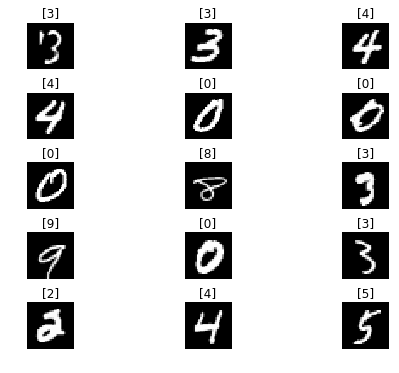

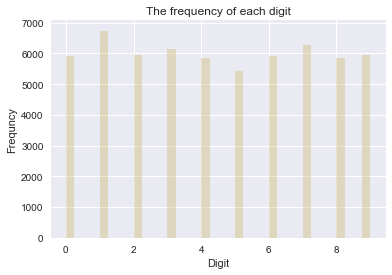

In [3]:
fig = plt.figure(figsize=(8, 6))
for i in range(15):
    fig.add_subplot(5, 3, i+1)
    index = rand.randint(0, len(MNIST_train_images-1))
    plt.title(MNIST_train_labels[index])
    plt.imshow(MNIST_train_images[index], cmap='gray')
    plt.axis('off')
fig.subplots_adjust(hspace=.5)
plt.show()

sns.set(color_codes=True)
sns.distplot(MNIST_train_labels, kde = False, color="y")
plt.title('The frequency of each digit')
plt.xlabel('Digit')
plt.ylabel('Frequncy')
plt.show()

# Concatenate digits in dataset

In [4]:
MNISTcat_test_images, MNISTcat_test_labels = randomly_concat_img(MNIST_test_images,MNIST_test_labels,5,(64,64))
MNISTcat_train_images, MNISTcat_train_labels = randomly_concat_img(MNIST_train_images,MNIST_train_labels,5,(64,64))

Concatenation and image resizing success!
Concatenation and image resizing success!


The training set has 27271 images
The test set has 4587 images


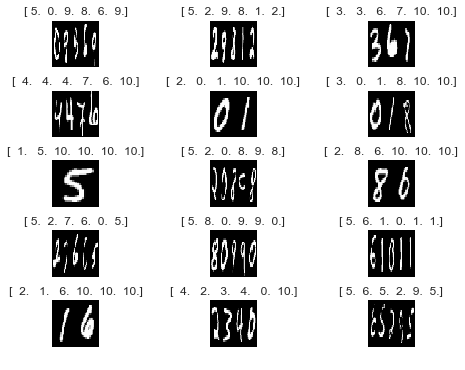

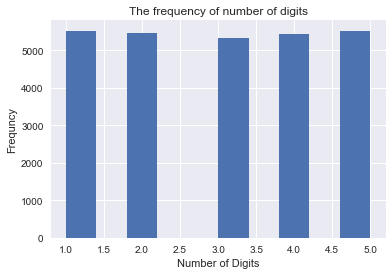

In [5]:
print('The training set has {} images'.format(len(MNISTcat_train_labels)))
print('The test set has {} images'.format(len(MNISTcat_test_labels)))


fig = plt.figure(figsize=(8, 6))
for i in range(15):
    fig.add_subplot(5, 3, i+1)
    index = rand.randint(0, len(MNISTcat_train_images-1))
    plt.title(MNISTcat_train_labels[index])
    plt.imshow(MNISTcat_train_images[index], cmap='gray')
    plt.axis('off')
fig.subplots_adjust(hspace=.5)
plt.show()

sns.set(color_codes=True)
plt.hist(MNISTcat_train_labels[1:,0])
plt.title('The frequency of number of digits')
plt.xlabel('Number of Digits')
plt.ylabel('Frequncy')
plt.show()
    

In [9]:
#Saving data
with open( "MNISTcat_train.pickle", "wb" ) as file:
    pickle.dump(( MNISTcat_train_images, MNISTcat_train_labels), file)
#Saving data
with open( "MNISTcat_test.pickle", "wb" ) as file:
    pickle.dump(( MNISTcat_test_images, MNISTcat_test_labels), file)

In [2]:
#Loading data
with open( "MNISTcat_train.pickle", "rb" ) as file:
    (MNISTcat_train_images, MNISTcat_train_labels) = pickle.load(file)
#Loading data
with open( "MNISTcat_test.pickle", "rb" ) as file:
    (MNISTcat_test_images, MNISTcat_test_labels) = pickle.load(file)

# Starting the implementation of convolutional neural network

In [5]:
num_classes = 61
img_rows, img_cols = 64, 64
batch_size = 128

X_train_MNIST, y_train_MNIST, X_test_MNIST, y_test_MNIST =\
MNISTcat_train_images, MNISTcat_train_labels, MNISTcat_test_images, MNISTcat_test_labels

if K.image_data_format() == 'channels_first':
    X_train_MNIST = X_train_MNIST.reshape(X_train_MNIST.shape[0], 1, img_rows, img_cols)
    X_test_MNIST = X_test_MNIST.reshape(X_test_MNIST.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train_MNIST = X_train_MNIST.reshape(X_train_MNIST.shape[0], img_rows, img_cols, 1)
    X_test_MNIST = X_test_MNIST.reshape(X_test_MNIST.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

y_enc = OneHotEncoder()
y_train_MNIST = np.array(y_enc.fit_transform(y_train_MNIST).todense())
y_test_MNIST = np.array(y_enc.fit_transform(y_test_MNIST).todense())

model_1 = naive_model(input_shape, num_classes)
model_2 = DNN_model(input_shape, num_classes)
model_3 = Deep_CNN(input_shape, num_classes)
model_4 = high_dropout_model(input_shape, num_classes)

model_list = [model_1, model_2, model_3, model_4]
history = {}
keys = ['model_1', 'model_2', 'model_3', 'model_4']

for i, model in enumerate(keys):
    early_stopping = EarlyStopping(monitor='val_loss', patience=2)
    history[model] = model_list[i].fit(X_train_MNIST, y_train_MNIST,
        batch_size=batch_size,
        verbose=2,
        epochs=20,
        validation_data=(X_test_MNIST, y_test_MNIST),
        callbacks=[early_stopping])
    score = model_list[i].evaluate(X_test_MNIST, y_test_MNIST, verbose=0)
    print('Fitting {} successful'.format(model))
    print('Test loss:', score[0])
    print('Test accuracy:', score[1]) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 30, 30, 32)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 28800)             0         
_________________________________________________________________
dense_27 (Dense)             (None, 64)                1843264   
_________________________________________________________________
dense_28 (Dense)             (None, 64)                4160      
__________

Epoch 6/20
 - 243s - loss: 0.0673 - acc: 0.9751 - val_loss: 0.0812 - val_acc: 0.9726
Epoch 7/20
 - 241s - loss: 0.0587 - acc: 0.9783 - val_loss: 0.0685 - val_acc: 0.9760
Epoch 8/20
 - 241s - loss: 0.0522 - acc: 0.9804 - val_loss: 0.0564 - val_acc: 0.9804
Epoch 9/20
 - 241s - loss: 0.0465 - acc: 0.9825 - val_loss: 0.0539 - val_acc: 0.9812
Epoch 10/20
 - 242s - loss: 0.0419 - acc: 0.9842 - val_loss: 0.0510 - val_acc: 0.9823
Epoch 11/20
 - 241s - loss: 0.0382 - acc: 0.9856 - val_loss: 0.0515 - val_acc: 0.9819
Epoch 12/20
 - 241s - loss: 0.0346 - acc: 0.9870 - val_loss: 0.0386 - val_acc: 0.9871
Epoch 13/20
 - 241s - loss: 0.0320 - acc: 0.9879 - val_loss: 0.0476 - val_acc: 0.9846
Epoch 14/20
 - 247s - loss: 0.0297 - acc: 0.9888 - val_loss: 0.0439 - val_acc: 0.9850
Fitting model_2 successful
Test loss: 0.0438937451246
Test accuracy: 0.985011090997
Train on 27271 samples, validate on 4587 samples
Epoch 1/20
 - 570s - loss: 0.4037 - acc: 0.8317 - val_loss: 0.1834 - val_acc: 0.9492
Epoch 2/20
 

AttributeError: Can't pickle local object 'strided_slice.<locals>.assign'

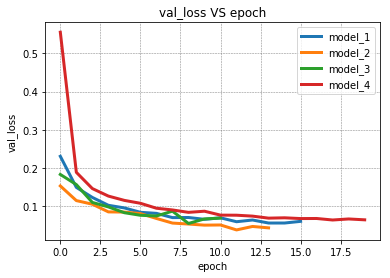

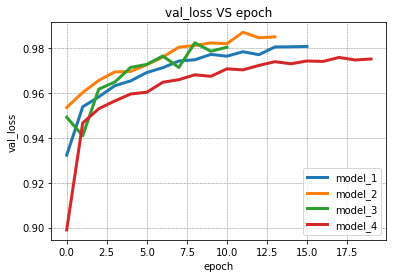

In [56]:
for model in keys:
    plt.plot(history[model].history['val_loss'], linewidth=3)
plt.legend(keys , loc='upper right')
plt.title('val_loss VS epoch')
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()

for model in keys:
    plt.plot(history[model].history['val_acc'], linewidth=3)
plt.legend(keys , loc='lower right')
plt.title('val_loss VS epoch')
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()
    

We can see that the highest accuracy is obtained from having more neurons and layers in fully connected layers. Therefore, the final model was introduced to get even higher accuracy by means of increasing nodes and layers.

In [5]:
model_5 = final_model(input_shape, num_classes)
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
model_5.fit(X_train_MNIST, y_train_MNIST,
            batch_size=batch_size,
            verbose=2,
            epochs=20,
            validation_data=(X_test_MNIST, y_test_MNIST),
            callbacks=[early_stopping])
score = model_5.evaluate(X_test_MNIST, y_test_MNIST, verbose=0)
print('Fitting model_5 successful')
print('Test loss:', score[0])
print('Test accuracy:', score[1]) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 28800)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               14746112  
_________________________________________________________________
dense_6 (Dense)              (None, 512)               262656    
__________

As we can see, high accuracy can be achieved, further improvement can still be done but we will consider current model to be good enough now. Example of the prediction is shown below.

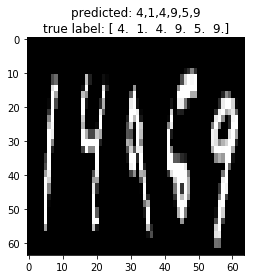

In [91]:
example_result = X_test_MNIST[3].reshape(img_rows, img_cols)
plt.imshow(example_result, cmap='gray')
plt.title('predicted: ' + get_integer(model_5.predict(X_test_MNIST[3].reshape(1, 64, 64, 1))) + '\n' \
          'true label: '+ str(MNISTcat_test_labels[3]))
plt.show()
